In [1]:
%matplotlib notebook
import ipympl
import unittest
import silq
silq.initialize("EWJN", mode='analysis')

from silq.tests.test_parameters import GaussianParameter, Gaussian2DParameter
from silq.measurements.measurement_modules import *
from silq.measurements.measurement_types import *
from silq.parameters.measurement_parameters import MeasurementSequenceParameter

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Initializing imports
Initializing functions
Initializing data
Initializing analysis
Initializing plotting
Initialization complete


In [2]:
dummy_parameter = ManualParameter(name='dummy', initial_value=0)
dummy_parameter2 = ManualParameter(name='dummy2', initial_value=0)
gaussian_parameter = GaussianParameter('gaussian', std=4,
                                       set_parameter=dummy_parameter)
gaussian_2D_parameter = Gaussian2DParameter('gaussian', std=4,
                                            set_parameters=[dummy_parameter, 
                                                            dummy_parameter2])

In [3]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run cell',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.restart_run_all();
        return false;
    }}
);

<IPython.core.display.Javascript object>

# Loop measurements

In [4]:
class TestLoopMeasurements(unittest.TestCase):
    def setUp(self):
        self.dummy_parameter = ManualParameter(name='dummy', initial_value=0)
        self.dummy_parameter2 = ManualParameter(name='dummy2', initial_value=0)
        self.gaussian_parameter = GaussianParameter('gaussian', std=4,
                                                    set_parameter=self.dummy_parameter, 
                                                    )
        self.gaussian_2D_parameter = Gaussian2DParameter('gaussian', std=4,
                                                         set_parameters=[self.dummy_parameter, 
                                                                         self.dummy_parameter2])

    def test_loop_0D_success(self):
        self.dummy_parameter(0) # At this value, gaussian_parameter equals 1
        loop0D_msmt = Loop0DMeasurement('loop_0D', 
                                        acquisition_parameter=self.gaussian_parameter,
                                        discriminant='gaussian')
        loop0D_msmt.condition_sets = [ConditionSet(('gaussian', '>', 0.9))]
        
        data = loop0D_msmt()
        self.assertEqual(data.gaussian.shape, (1,))

        optimum_values = loop0D_msmt.get_optimum()
        self.assertEqual(optimum_values[1], 1)

    def test_loop_0D_fail(self):
        self.dummy_parameter(4) # At this value, gaussian_parameter is below 1
        loop0D_msmt = Loop0DMeasurement('loop_0D', 
                                        acquisition_parameter=self.gaussian_parameter,
                                        discriminant='gaussian')
        loop0D_msmt.condition_sets = [ConditionSet(('gaussian', '>', 0.9))]
        
        data = loop0D_msmt()
        self.assertEqual(data.gaussian.shape, (1,))

        optimum_values = loop0D_msmt.get_optimum()
        self.assertTrue(np.isnan(optimum_values[1]))

    def test_loop_1D_success(self):
        # Set dummy parameter to a non-optimal value
        self.dummy_parameter(1)
        
        loop1D_msmt = Loop1DMeasurement(
            'loop_1D', 
            acquisition_parameter=self.gaussian_parameter, 
            set_parameter=self.dummy_parameter, 
            discriminant='gaussian')
        condition_set = ConditionSet(('gaussian', '>', 0.9), update=True)
        loop1D_msmt.condition_sets = [condition_set]

        loop1D_msmt(step=1, points=11)
        data = loop1D_msmt()
        self.assertEqual(data.gaussian.shape, (11,))
        
        optimum_parameter, optimum_value = loop1D_msmt.get_optimum()
        self.assertEqual(optimum_parameter['dummy'], 0)
        self.assertEqual(optimum_value, 1)
        
        # Verify that parameter is updated
        self.assertEqual(self.dummy_parameter(), 0)

    def test_loop_1D_fail(self):
        # Set dummy parameter to a non-optimal value
        self.dummy_parameter(1)
        
        loop1D_msmt = Loop1DMeasurement(
            'loop_1D', 
            acquisition_parameter=self.gaussian_parameter, 
            set_parameter=self.dummy_parameter, discriminant='gaussian')
        condition_set = ConditionSet(('gaussian', '>', 1.1), update=False)
        loop1D_msmt.condition_sets = [condition_set]

        loop1D_msmt(step=0.1, points=11)
        data = loop1D_msmt()
        self.assertEqual(data.gaussian.shape, (11,))
        
        optimum_parameter, optimum_value = loop1D_msmt.get_optimum()
        self.assertTrue(np.isnan(optimum_parameter['dummy']))
        self.assertTrue(np.isnan(optimum_value))

        # Verify that parameter is not updated
        self.assertEqual(self.dummy_parameter(), 1)

    def test_loop_2D_success(self):
        # Set parameters to non-potimal values
        self.dummy_parameter(2)
        self.dummy_parameter2(-3)
        
        loop2D_msmt = Loop2DMeasurement(
            'loop_2D', 
            acquisition_parameter=self.gaussian_2D_parameter, 
            set_parameters=[self.dummy_parameter2, self.dummy_parameter],
            discriminant='gaussian', silent=True)
        condition_set = ConditionSet(('gaussian', '>', 0.99), update=True)
        loop2D_msmt.condition_sets = [condition_set]
        loop2D_msmt(step=1, points=11)
        data =loop2D_msmt()
        
        optimum_parameter, optimum_value = loop2D_msmt.get_optimum()
        self.assertEqual(optimum_value, 1)
        
        self.assertEqual(self.dummy_parameter(), 0)
        self.assertEqual(self.dummy_parameter2(), 0)

# Measurement Parameters

## Peak parameter

dummy_parameter2(3)


from silq.parameters.measurement_parameters import TrackPeakParameter

peak_parameter = TrackPeakParameter('track', 
                                    set_parameter=dummy_parameter2,
                                    acquisition_parameter=gaussian_2D_parameter,
                                    peak_width=3, points=11,
                                    discriminant='gaussian',
                                    silent=False, threshold=0.2)

data = qc.Loop(dummy_parameter[-3:6:0.5]).each(peak_parameter).run(name='test', background=False)

data.sync()
data.optimal_set_vals

plot = qc.MatPlot(subplots=2)
plot[0].add(data.gaussian)
plot[1].add(data.optimal_set_vals)

## Calibration parameter

loop = Loop2DMeasurement('detailed',
                         step=0.1,
                         points=5,
                         set_parameters=[dummy_parameter,
                                         dummy_parameter2],
                         acquisition_parameter=gaussian_2D_parameter,
                         discriminant='gaussian')

condition_sets = [ConditionSet(('gaussian', '>', 0.4), 
                               on_success='success', 
                               update=True)]
measurements = [
    Loop2DMeasurement('detailed',
                      step=0.1,
                      points=5,
                      set_parameters=[dummy_parameter,
                                      dummy_parameter2],
                      discriminant='gaussian'),
    Loop2DMeasurement('rough',
                      step=0.1,
                      points=5,
                      set_vals=[dummy_parameter[-5:5:1], 
                                dummy_parameter2[-5:5:1]],
                      discriminant='gaussian')]
                
measurement_sequence = MeasurementSequence('retune', 
                                           measurements=measurements,
                                           acquisition_parameter=gaussian_2D_parameter,
                                           condition_sets=condition_sets, 
                                           silent=False)

In [92]:
class TestCalibration(unittest.TestCase):
    def setUp(self):
        self.dummy_parameter = ManualParameter(name='dummy', initial_value=0)
        self.dummy_parameter2 = ManualParameter(name='dummy2', initial_value=0)
        self.gaussian_parameter = GaussianParameter('gaussian', std=4,
                                                    set_parameter=self.dummy_parameter, 
                                                    )
        self.gaussian_2D_parameter = Gaussian2DParameter('gaussian', std=4,
                                                         set_parameters=[self.dummy_parameter, 
                                                                         self.dummy_parameter2])
        
        self.detailed_measurement = Loop2DMeasurement(
            'detailed', step=0.1, points=11, discriminant='gaussian',
            set_parameters=[self.dummy_parameter, self.dummy_parameter2])
        self.rough_measurement = Loop2DMeasurement(
            'rough', step=1, points=11, discriminant='gaussian',
            set_parameters=[self.dummy_parameter, self.dummy_parameter2])
        self.measurements = [self.detailed_measurement, self.rough_measurement]
    
        self.measurement_sequence = MeasurementSequence(
            'retune', measurements=self.measurements, 
            acquisition_parameter=self.gaussian_2D_parameter,
            silent=True)
        
    def test_measurement_sequence_success(self):
        self.dummy_parameter(4)
        self.dummy_parameter2(4)
        
        self.measurement_sequence.condition_sets = [
            ConditionSet(('gaussian', '>', 0.4), on_success='success', update=True)]
        
        result = self.measurement_sequence()
        
        self.assertTrue(result['is_satisfied'])
        self.assertEqual(result['action'], 'success')
        self.assertEqual(result['measurement'], 'rough')
        self.assertEqual(self.dummy_parameter(), 0)
        self.assertEqual(self.dummy_parameter2(), 0)
        
    def test_measurement_sequence_fail(self):
        self.dummy_parameter(2)
        self.dummy_parameter2(3)
        
        self.measurement_sequence.condition_sets = [
            ConditionSet(('gaussian', '>', 1.1), on_success='success', update=True)]
        
        result = self.measurement_sequence()
        
        self.assertFalse(result['is_satisfied'])
        self.assertEqual(result['action'], 'fail')
        self.assertEqual(result['measurement'], 'rough')
        self.assertEqual(self.dummy_parameter(), 2)
        self.assertEqual(self.dummy_parameter2(), 3)
        
    def test_measurement_parameter_success_detailed(self):
        self.dummy_parameter(0)
        self.dummy_parameter2(0.4)
        
        self.measurement_sequence.condition_sets = [
            ConditionSet(('gaussian', '>', 0.9), on_success='success', update=True)]
        retune_parameter = MeasurementSequenceParameter(
            'retune_parameter', 
            self.measurement_sequence,
            set_parameters=[self.dummy_parameter, self.dummy_parameter2])
        
        data = qc.Measure(retune_parameter).run(quiet=True)
        
        self.assertEqual(data.retune_parameter_msmts[0], 1)
        self.assertEqual(data.gaussian[0], 1)
        self.assertAlmostEqual(data.optimal_set_vals[0], 0)
        self.assertAlmostEqual(data.optimal_set_vals[1], 0)
        self.assertAlmostEqual(self.dummy_parameter(), 0)
        self.assertAlmostEqual(self.dummy_parameter2(), 0)
        
    def test_measurement_parameter_success_rough(self):
        self.dummy_parameter(3)
        self.dummy_parameter2(2)
        
        self.measurement_sequence.condition_sets = [
            ConditionSet(('gaussian', '>', 0.9), on_success='success', update=True)]
        retune_parameter = MeasurementSequenceParameter(
            'retune_parameter', 
            self.measurement_sequence,
            set_parameters=[self.dummy_parameter, self.dummy_parameter2])
        
        data = qc.Measure(retune_parameter).run(quiet=True)
        
        self.assertEqual(data.retune_parameter_msmts[0], 2)
        self.assertEqual(data.gaussian[0], 1)
        self.assertAlmostEqual(data.optimal_set_vals[0], 0)
        self.assertAlmostEqual(data.optimal_set_vals[1], 0)
        self.assertAlmostEqual(self.dummy_parameter(), 0)
        self.assertAlmostEqual(self.dummy_parameter2(), 0)
        
    def test_measurement_parameter_fail(self):
        self.dummy_parameter(10)
        self.dummy_parameter2(5)
        
        self.measurement_sequence.condition_sets = [
            ConditionSet(('gaussian', '>', 0.9), on_success='success', update=True)]
        retune_parameter = MeasurementSequenceParameter(
            'retune_parameter', 
            self.measurement_sequence,
            set_parameters=[self.dummy_parameter, self.dummy_parameter2])
        
        data = qc.Measure(retune_parameter).run(quiet=True)
        
        self.assertEqual(data.retune_parameter_msmts[0], 2)
        self.assertTrue(np.isnan(data.gaussian[0]))
        self.assertAlmostEqual(data.optimal_set_vals[0], 10)
        self.assertAlmostEqual(data.optimal_set_vals[1], 5)
        self.assertAlmostEqual(self.dummy_parameter(), 10)
        self.assertAlmostEqual(self.dummy_parameter2(), 5)

In [93]:
# Run tests    
suite_loop_measurements = unittest.TestLoader().loadTestsFromModule(TestLoopMeasurements())
suite_calibration = unittest.TestLoader().loadTestsFromModule((TestCalibration()))
suite = unittest.TestSuite([suite_loop_measurements, suite_calibration])
unittest.TextTestRunner(verbosity=2, failfast=True).run(suite)

test_loop_0D_fail (__main__.TestLoopMeasurements) ... ok
test_loop_0D_success (__main__.TestLoopMeasurements) ... ok
test_loop_1D_fail (__main__.TestLoopMeasurements) ... ok
test_loop_1D_success (__main__.TestLoopMeasurements) ... ok
test_loop_2D_success (__main__.TestLoopMeasurements) ... ok
test_measurement_parameter_fail (__main__.TestCalibration) ... ok
test_measurement_parameter_success_detailed (__main__.TestCalibration) ... ok
test_measurement_parameter_success_rough (__main__.TestCalibration) ... ok
test_measurement_sequence_fail (__main__.TestCalibration) ... ok
test_measurement_sequence_success (__main__.TestCalibration) ... ok

----------------------------------------------------------------------
Ran 10 tests in 1.328s

OK


<unittest.runner.TextTestResult run=10 errors=0 failures=0>

In [6]:
detailed_measurement = Loop2DMeasurement(
    'detailed', step=0.1, points=5, discriminant='gaussian',
    set_parameters=[dummy_parameter, dummy_parameter2])
rough_measurement = Loop2DMeasurement(
    'rough', step=1, points=11, discriminant='gaussian',
    set_parameters=[dummy_parameter, dummy_parameter2])
measurements = [detailed_measurement, rough_measurement]

measurement_sequence = MeasurementSequenceParameter(
    'retune_parameter', measurement_sequence,
    set_parameters=[self.dummy_parameter, self.dummy_parameter2])

measurement_sequence.condition_sets = [
    ConditionSet(('gaussian', '>', 0.9), on_success='success', update=True)]

Performing measurement detailed measurement
Finished measurements
DataSet:
   mode     = DataMode.LOCAL
   location = '2017-04-12/#373_{name}_16-07-57'
   <Type>   | <array_id>             | <array.name>           | <array.shape>
   Setpoint | single_set             | single                 | (1,)
   Setpoint | index0_set             | index0                 | (2,)
   Measured | retune_parameter_msmts | retune_parameter_msmts | (1,)
   Measured | optimal_set_vals       | optimal_set_vals       | (2,)
   Measured | gaussian               | gaussian               | (1,)
acquired at 2017-04-12 16:07:57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


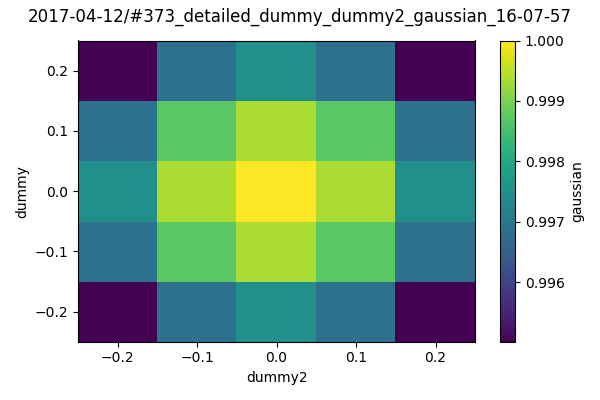

In [7]:
from silq.parameters.measurement_parameters import MeasurementSequenceParameter

retune_parameter = MeasurementSequenceParameter('retune_parameter', measurement_sequence,
                                                set_parameters=[dummy_parameter, dummy_parameter2])

data = qc.Measure(retune_parameter).run()

dataset = measurement_sequence.datasets[0]
qc.MatPlot(dataset.gaussian)

# Run tests